In [1]:
import pystac_client
import planetary_computer
import rioxarray as rio
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from shapely import Point
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import cartopy.crs as ccrs
import xrspatial as xrs
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
db = ox.features_from_place('Pinzolo', tags={'name':'Dolomiti di Brenta',
                                             'place':'region',
                                             'type':'boundary',
                                             'region:type':'mountain_area'
                                             }).loc['way']

west, south, east, north = db.total_bounds
crs = db.estimate_utm_crs()
prj = ccrs.UTM(crs.utm_zone.split('N')[0])

fs = ox.features_from_bbox(north=north, south=south, east=east, west=west,
                           tags={'natural':['peak','glacier','saddle','cliff',
                                            'water','bare_rock','scree',
                                            'scrub','grassland'],
                                 'water':'lake',
                                #  'landuse':['forest','meadow'],
                                #  'highway':'path',
                                #  'tourism':'alpine_hut'
                                 }).reset_index()

fs = fs.clip(db.envelope, keep_geom_type=False)
fs = fs.to_crs(prj)
db = db.to_crs(prj)

In [3]:

lakes = fs.loc[fs['water']=='lake']
peak = fs.loc[fs['natural']=='peak']
glacier = fs.loc[fs['natural']=='glacier']
cliff = fs.loc[fs['natural']=='cliff']
cliff = cliff.loc[~(cliff.geom_type=='Point')]
water = fs.loc[fs['natural']=='water']

# rifugio = fs.loc[fs['tourism']=='alpine_hut'].copy()
# rifugio['geometry'] = rifugio.centroid
# paths = fs.loc[fs['highway']=='path']
# saddle = fs.loc[fs['natural']=='saddle']
# bare_rock = fs.loc[fs['natural']=='bare_rock']
# scree = fs.loc[fs['natural']=='scree']
# scrub = fs.loc[fs['natural']=='scrub']
# grassland = fs.loc[fs['natural']=='grassland']
# forest = fs.loc[fs['landuse']=='forest']
# meadow = fs.loc[fs['landuse']=='meadow']

In [4]:
### get elevations
aoi = db.to_crs(4326).envelope.values[0]

## get contours in aoi from copernicus global DEM hosted on planetary computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=['cop-dem-glo-30'],
                        intersects=aoi)
items = list(search.get_items())

# if aoi crosses multiple DEM tiles stitch 'em together
if len(items) > 1:
    data = []
    for item in items:
        signed_asset = planetary_computer.sign(item.assets["data"])
        with rio.open_rasterio(signed_asset.href) as f:
            data.append(f.squeeze().drop_vars("band").rename('z'))
    dem = ((xr.merge(data))
           .rio.set_crs(4326)
           .rio.clip_box(*aoi.bounds))['z']
else:
    signed_asset = planetary_computer.sign(items[0].assets["data"])
    dem =  (rio.open_rasterio(signed_asset.href)
            .squeeze()
            .rio.set_crs(4326)
            .rio.clip_box(*aoi.bounds)).rename('z')
    
# reproject to local utm crs
dem_prj = dem.rio.reproject(prj, resolution=30, nodata=np.nan)

# dump out arrays
Z = dem_prj.values
X,Y = np.meshgrid(dem_prj.x.values, dem_prj.y.values)

hillshade = xrs.hillshade(dem_prj, azimuth=100, angle_altitude=45)

c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\site-packages\pystac_client\item_search.py:817: DeprecationWarning: get_items() is deprecated, use items() instead
  warnings.warn(
c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\abc.py:123: ResourceWarning: unclosed <ssl.SSLSocket fd=5000, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.0.53', 64539), raddr=('13.107.246.64', 443)>
  return _abc_subclasscheck(cls, subclass)


In [ ]:
# scree.plot(ax=ax, fc='none', hatch='....', ec='lightgrey', alpha=0.3)
# bare_rock.plot(ax=ax, fc='burlywood', alpha=0.3)
# meadow.plot(ax=ax, ec='none', fc='lawngreen', alpha=0.3)
# forest.plot(ax=ax, ec='none', fc='forestgreen', alpha=0.3)
# grassland.plot(ax=ax, ec='none', fc='yellowgreen', alpha=0.3)
# scrub.plot(ax=ax, ec='none', fc='olivedrab', alpha=0.3)
# paths.plot(ax=ax, linewidth=0.2, color='lightcoral')
# rifugio.plot(ax=ax, marker = 's', markersize=2, fc='none', ec='darkorchid')
# saddle.plot(ax=ax, marker = 'v', markersize=4, ec='tab:orange', fc='none')

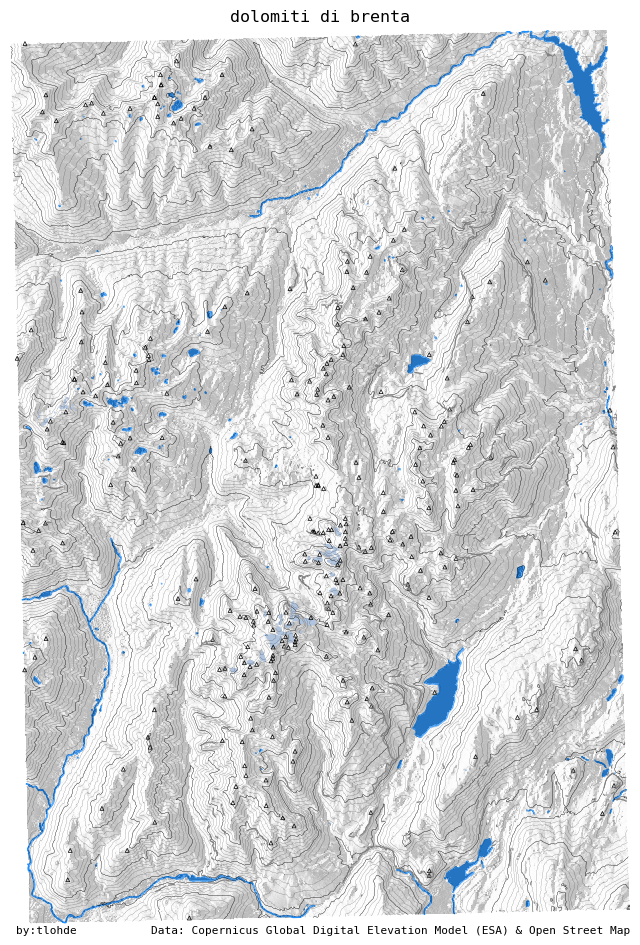

In [7]:
fig, ax = plt.subplots(figsize=[8,13],subplot_kw={'projection':prj})

ax.contour(X,Y,Z,
           levels=[i for i in range(0,4000,100)],
           colors='k',
           linewidths = 0.1, linestyles='solid')
cntr = ax.contour(X,Y,Z,
                  levels=[i for i in range(0,4000,500)],
                  colors='k',
                  linewidths=0.2)
# ax.clabel(cntr, cntr.levels, fontsize=8)

cliff.plot(ax=ax, color='grey', linewidth=0.8)
water.plot(ax=ax, fc='dodgerblue', ec='dodgerblue')
glacier.plot(ax=ax, fc='lightsteelblue', ec='lightsteelblue')

hillshade.plot(ax=ax, cmap='Greys', alpha=0.3, add_colorbar=False)
glacier.plot(ax=ax, fc='lightsteelblue', ec='lightsteelblue')

peak.plot(ax=ax, marker='^', fc='none', ec='k', markersize=8, linewidth=0.5)
ax.set_title('dolomiti di brenta')
ax.set_axis_off()
ax.annotate(text='Data: Copernicus Global Digital Elevation Model (ESA) & Open Street Map',
            xy=(1,-0.01), 
            xycoords='axes fraction', 
            ha='right',
            c='k', 
            fontsize=8,
            font='DejaVu Sans Mono')

ax.annotate(text='by:tlohde',
            xy=(0.01,-0.01), 
            xycoords='axes fraction',
            ha='left',
            fontsize=8,
            font='DejaVu Sans Mono')

fig.savefig('day14.png', bbox_inches='tight', dpi=300)